## Creating our own Reinforcement learning environment

In [1]:
pip install opencv-python

  Using cached opencv_python-4.5.3.56-cp38-cp38-manylinux2014_x86_64.whl (49.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
style.use("ggplot")

 on # 0, epsilon:0.9
 3000 ep mean nan
 on # 3000, epsilon:0.49390083359356435
 3000 ep mean -172.11166666666668
 on # 6000, epsilon:0.27104225936046566
 3000 ep mean -119.501
 on # 9000, epsilon:0.14874221981913022
 3000 ep mean -90.26466666666667
 on # 12000, epsilon:0.08162656262136181
 3000 ep mean -70.242
 on # 15000, epsilon:0.044794919246742226
 3000 ep mean -58.45466666666667
 on # 18000, epsilon:0.024582497729691496
 3000 ep mean -48.340333333333334
 on # 21000, epsilon:0.01349035124500733
 3000 ep mean -40.43933333333333
 on # 24000, epsilon:0.0074032174726434705
 3000 ep mean -37.80866666666667


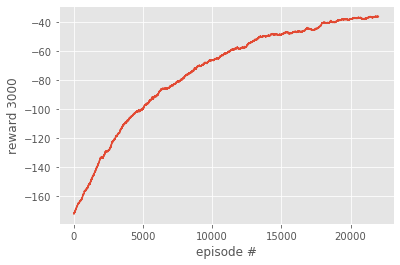

In [10]:
#IN ORDERT TO MAKE A 10*10 GRID
SIZE=10
HM_EPISODES= 25000
MOVE_PENALTY=1

# IF WE HIT THE ENEMY
ENEMY_PENALTY=300
FOOD_REWARD=25


epsilon=0.9
EPS_DECAY=0.9998
SHOW_EVERY=3000

start_q_table= None # or file name

LEARNING_RATE= 0.1
DISCOUNT= 0.95

# NUMBERS FOR LABELS FOR KEYS IN A DICTIONARY
PLAYER_N=1
FOOD_N=2
ENEMY_N=3
# these will be the colors
d= {1: (255, 175, 0),
    2: (0, 255, 0), 
    3: (0, 0, 255)}


class Blob:
    def __init__(self):
        self.x=np.random.randint(0, SIZE)
        self.y=np.random.randint(0, SIZE)
        
    def __str__(self):
        return f"{self.x}, {self.y} "
    
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    
    def action(self, choice):
    #it can only move diagonally    
        if choice==0:
            self.move(x=1, y=1)
        elif choice==1:
            self.move(x=-1, y=-1)
        elif choice==2:
            self.move(x=-1, y=1)
        elif choice==3:
            self.move(x=1, y=-1)
    
    def move(self, x=False, y=False):
        if not x:
            self.x+= np.random.randint(-1, 2)
        else:
            self.x+=x
            
        if not y:
            self.y+= np.random.randint(-1, 2)
        else:
            self.y+=y
            
        if self.x<0:
            self.x=0
        elif self.x> SIZE-1:
            self.x=SIZE-1
            
        if self.y<0:
            self.y=0
        elif self.y> SIZE-1:
            self.y=SIZE-1
            
            
if start_q_table is None:
    
    q_table={}
    
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[((x1, y1),(x2, y2))]=[np.random.uniform(-5, 0) for i in range(4)]

else:
    with open(start_q_table, "rb") as f:
        q_table=pickle.load(f)
            
episode_rewards =[]           
for episode in range(HM_EPISODES):
    player=Blob()
    food=Blob()
    enemy=Blob()
    
    if episode% SHOW_EVERY==0:
        print(f" on # {episode}, epsilon:{epsilon}")
        print(f" {SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show= True
    else:
        show=False
        
    episode_reward=0
    #for how many steps we will take
    for i in range(200):
        obs=(player-food, player-enemy)
        if np.random.random()>epsilon:
            action=np.argmax(q_table[obs])
        else:
            action=np.random.randint(0,4)
            
        player.action(action)
        
        
        if player.x==enemy.x and player.y==enemy.y:
            reward= -ENEMY_PENALTY
        elif player.x==food.x and player.y==food.y:
            reward= FOOD_REWARD
        else:
            reward= -MOVE_PENALTY
        
        new_obs=(player-food, player-enemy)
        max_future_q=np.max(q_table[new_obs])
        current_q= q_table[obs][action]
        
        if reward== FOOD_REWARD:
            new_q= FOOD_REWARD
        elif reward== -ENEMY_PENALTY:
            new_q= -ENEMY_PENALTY
        else:
            new_q= (1-LEARNING_RATE)*current_q+ LEARNING_RATE*(reward+DISCOUNT*max_future_q)
        q_table[obs][action]= new_q
        
        if show:
            env=np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            env[player.y][player.x]= d[PLAYER_N]
            env[food.y][food.x]= d[FOOD_N]
            env[enemy.y][enemy.x]= d[ENEMY_N]
            
            img=Image.fromarray(env, 'RGB')
            img=img.resize((300,300))
            cv2.imshow("", np.array(img))
        
            if reward== FOOD_REWARD or reward== -ENEMY_PENALTY:
                if cv2.waitKey(500) and 0xFF== ord("q"):
                    break
        
                else:
                    if cv2.waitKey(1) and 0xFF== ord("q"):
                        break
                        
        episode_reward+=reward
        if reward== FOOD_REWARD or reward==-ENEMY_PENALTY:
            break
            
    episode_rewards.append(episode_reward)
    epsilon*=EPS_DECAY

moving_avg= np.convolve(episode_rewards, np.ones((SHOW_EVERY, ))/SHOW_EVERY, mode="valid")
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"reward {SHOW_EVERY}")
plt.xlabel("episode #")
plt.show()
with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)
        
        